# Analyse der Plenarprotokolle - Basis Emotionen
## Dataset preparation - Kommentar

In [8]:
import pickle, gensim, numpy as np
import pandas as pd 

PICKLE_FOLDER_PATH = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Plenum/'

# Aktueller Datensatz (ohne Label)
df = pickle.load(open(PICKLE_FOLDER_PATH + 'df_comment_all_date.pickle', "rb" )) # 232077

# Ergebnisse in 24 dict - nicht relativiert mit Wordcount
df_kom = pickle.load(open(PICKLE_FOLDER_PATH + 'dic_kommentare_BE', "rb" ))
len(df_kom)

# Datum drin und richtige cols aber Kommentare nicht mit RegEx gesplittet!
#df_date = pickle.load(open(PICKLE_FOLDER_PATH + 'df_comment_date_correct.pickle', "rb" )) #232077

24

In [11]:
df_kom['FDP_Text1']

,Rede_ID,FDP_Text1
35,ID19100400,mir kommen die tränen!
36,ID19100400,zur sache!
37,ID19100400,traditionen wollten sie doch direkt brechen!
38,ID19100400,stimmt gar nicht!
45,ID19100400,rabulisten!
...,...,...
231953,ID1917015400,das liegt ja an ihnen!
231977,ID1917015500,verbieten sie zigaretten doch!
231978,ID1917015500,warum verbieten sie zigaretten eigentlich nich...
231985,ID1917015600,"bei uns auch! bei uns noch vielmehr, trotz wer..."


##### Bearbeiten bzw vereinheitlichen der Fraktions Spalte

In [6]:
import re
df = df[df['Fraktion'] != 'Bremen']
df['Fraktion'] = df['Fraktion'].replace(to_replace=r'(BÜNDNIS(SES)*\s90\/DIE\sGRÜNEN)[$:,]*(?i)', value='BÜNDNIS_90/DIE_GRÜNEN', regex=True)
df['Fraktion'] = df['Fraktion'].replace(to_replace=r'((DIE )*LINKE)[N$:,]*', value='DIE_LINKE', regex=True)
df['Fraktion'] = df['Fraktion'].replace(to_replace=r'(Fraktionslos(?i))', value='Fraktionslos', regex=True)
df['Fraktion'] = df['Fraktion'].replace(to_replace=r'(SPD.*)', value='SPD', regex=True)

##### Erstelle Dictionary mit Kommentaren und Text Cleaning

In [9]:
parteien = ['SPD', 'FDP', 'AfD', 'CDU/CSU', 'BÜNDNIS_90/DIE_GRÜNEN', 'DIE_LINKE']

dic_kommentare = {}
for partei in parteien:
    df_comment = df[['Rede_ID', partei+'_Text1', partei+'_Text2']]    
    
    dic_kommentare[partei+'_Text1'] = df_comment.loc[df_comment[partei+'_Text1']!=''][['Rede_ID', partei+'_Text1']]
#     dic_kommentare[partei+'_Text1'].index = dic_kommentare[partei+'_Text1']['Rede_ID']
    dic_kommentare[partei+'_Text1'][partei+'_Text1'] = dic_kommentare[partei+'_Text1'][partei+'_Text1'].map(lambda x: re.sub('§[\n\t,\.!?#@\\n"“„\:;&\(\)]', '', x))
    dic_kommentare[partei+'_Text1'][partei+'_Text1'] = dic_kommentare[partei+'_Text1'][partei+'_Text1'].map(lambda x: x.lower())
    
    dic_kommentare[partei+'_Text2'] = df_comment.loc[df_comment[partei+'_Text2']!=''][['Rede_ID', partei+'_Text2']]
#     dic_kommentare[partei+'_Text2'].index = dic_kommentare[partei+'_Text2']['Rede_ID']
    dic_kommentare[partei+'_Text2'][partei+'_Text2'] = dic_kommentare[partei+'_Text2'][partei+'_Text2'].map(lambda x: re.sub('§[\n\t,\.!?#@\\n"“„\:;&\(\)]', '', x))
    dic_kommentare[partei+'_Text2'][partei+'_Text2'] = dic_kommentare[partei+'_Text2'][partei+'_Text2'].map(lambda x: x.lower())

## Dataset preparation - Reden

In [14]:
import re

sample_df = df[df['Rede_Text'].isna() != True]

# Remove punctuation
sample_df['full_text_processed'] = sample_df['Rede_Text'].map(lambda x: re.sub('§[\n\t,\.!?#@\\n"“„\:;&\(\)]', '', x))

# Convert the titles to lowercase
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

sample_df = sample_df[sample_df['full_text_processed'] != '']
sample_df = sample_df[sample_df['full_text_processed'] != ' ']
sample_df = sample_df[sample_df['full_text_processed'] != '   ']

df_Reden = sample_df[['Rede_ID', 'full_text_processed']]
df_Reden.columns = ['Rede_ID', 'Text']
df_Reden = df_Reden.groupby('Rede_ID')['Text'].apply(' '.join).reset_index() #17086

/usr/local/anaconda3/bin/ipython:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/bin/ipython:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Basic Emotions
##### 1.) Erstellen der EmotionsMatrix - Kommentare und Reden

In dieser Matrix steht jede Zeile für ein deutsches Wort, welches den Wert 1 zugeschrieben bekommt, wenn eine der sieben "Basis Emotionen" damit verbunden ist.

In [98]:
%%time
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm


import csv
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
######### Erstelle Emotions-Matrix

filepath = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Lexicon_based/german-emotion-dictionary/fundamental/'
emo_df = []
words = []
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
emotion_list= {}
stemmer = SnowballStemmer("german")

for emo in emotion:
    with open(filepath + emo + '.txt', newline='\n') as f:
        reader = csv.reader(f)
        data = [item for sublist in reader for item in sublist] 
        emotion_list[str(emo)] = data
        words.extend(data)
        
words = list(set(words)) # remove Duplicates which come from overlapping EmotionLists
emo_df  = pd.DataFrame(index=words, columns=emotion)

words = []
for word in emo_df.index:
    for emo in emo_df.columns:
        if word in emotion_list[emo]:
            emo_df.at[word, emo] = 1
        else:
            emo_df.at[word, emo] = 0
    words.append(stemmer.stem(word.lower()))
 
emo_df.index= words
emo_df = emo_df.sort_index(ascending=True)
emo_df = pd.DataFrame(emo_df)
emo_df = emo_df.loc[~emo_df.index.duplicated(keep='first')]

emo_df.head()


CPU times: user 823 ms, sys: 78 µs, total: 823 ms
Wall time: 884 ms


,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut
aalglatt,0,0,0,0,0,1,0
aasgei,0,0,0,0,0,1,0
abbrech,0,0,0,1,0,0,0
abbruchreif,0,0,0,0,0,1,0
abbugeln,0,0,0,0,0,1,0


## Anwendung der Emotions Matrix auf Kommentare
Jedes Wort in jedem Kommentar wird in der Matrix gesucht und ggf. der Vektor zurückgegeben. 
Siehe Kommentare

In [15]:
# %%time
# emo_base_df = sample_df['full_text_processed']
# for partei in parteien:
#     emo_base_df = dic_kommentare[partei+'_Text2'][partei+'_Text2']
#     df_emo = pd.DataFrame(0, index=emo_base_df.index, columns=emotion)

#     for i in emo_base_df.index:
#         document = word_tokenize(emo_base_df.loc[i])
#         for word in document:
#             word = stemmer.stem(word.lower())             # Stemming des einzelnen Wortes aus Tweet um es...
#             emo_score = emo_df[emo_df.index == word]      # ... mit den Lexikon Worten zu vergleichen -> emo_score 

#             if not emo_score.empty:                       # der emo score eines Worts z.B. [0 0 1 1 0 0 0] 
#                 for emot in emotion:                      # wird zum Score des Tweets dazugezählt z.B.: [2 0 4 1 0 0 0]
#                     df_emo.at[i, emot] += emo_score[emot] # am Ende exisitiert zu einem Tweet ein 7-dim Vektor


#     dic_kommentare[partei+'_Text2_BE'] = pd.concat([emo_base_df, df_emo], axis=1)

# emo_base_df.head(20)

## Load/ Dump einfache Matrix (nicht relativ, aber mit id) - Kommentare

In [ ]:
import pickle, gensim, numpy as np
# pickle.dump(emo_base_df, open(PICKLE_FOLDER_PATH + 'dic_komentare_BE', "wb" ))
df_kom = pickle.load(open(PICKLE_FOLDER_PATH + 'dic_komentare_BE', "rb" ))

## Anwendung der Emotions Matrix auf Reden

In [99]:
%%time #####################################
emo_base_df = df_Reden['Text']
df_emo = pd.DataFrame(0, index=emo_base_df.index, columns=emotion)

for i in emo_base_df.index:
    document = word_tokenize(emo_base_df.loc[i])
    for word in document:
        word = stemmer.stem(word.lower())             # Stemming des einzelnen Wortes aus Tweet um es...
        emo_score = emo_df[emo_df.index == word]      # ... mit den Lexikon Worten zu vergleichen -> emo_score 

        if not emo_score.empty:                       # der emo score eines Worts z.B. [0 0 1 1 0 0 0] 
            for emot in emotion:                      # wird zum Score des Tweets dazugezählt z.B.: [2 0 4 1 0 0 0]
                df_emo.at[i, emot] += emo_score[emot] # am Ende exisitiert zu einem Tweet ein 7-dim Vektor


emo_base_df = pd.concat([emo_base_df, df_emo], axis=1)

emo_base_df.head(20)

CPU times: user 2h 41min 3s, sys: 5.13 s, total: 2h 41min 8s
Wall time: 2h 48min 58s


Text  \
0   sehr geehrter herr präsident! liebe kolleginnen und kollegen! in der kommenden woche wählen wir europäer ein neues parlament. ich möchte daher einige einleitende worte zu dieser besonderen wahl sagen. für bildung und forschung ist die europäische union nämlich ein echter glücksfall. durch schüler-, azubi- und studentenaustausche sind millionen von persönlichen beziehungen entstanden. es sind diese geschichten, die unser europäisches haus mit leben füllen. die wissenschaft ist durch europa enger vernetzt denn je. forscher kämpfen gemeinsam gegen krebs, tüfteln an neuen innovationen und setzen sich für den schutz unseres klimas ein. mit einer gut vernetzten bildungs- und forschungslandschaft ist europa ein ort der chancen. deshalb ist es wichtig, dass die europäische union aus der anstehenden wahl gestärkt hervorgeht, damit wir uns dann gemeinsam und entschlossener denn je den großen zukunftsfragen unseres kontinents widmen können. das leben der menschen durch bildung und forschung ein klein wenig besser zu machen, ist natürlich auch unser anspruch hier in deutschland. die leistungsfähigkeit unseres bildungssystems ist international und auch hier im land hoch anerkannt. fortschritte in der forschung schaffen immer neue möglichkeiten für ein besseres und gesünderes leben, für eine leistungsfähigere und stets wettbewerbsfähige wirtschaft und mittlerweile auch für immer weiter gehende erkenntnisse über die grundlagen unserer existenz. lassen sie mich einige punkte explizit nennen. erstens. wir verbessern die startbedingungen für studierende und auszubildende. es ist noch nicht lange her, dass wir die drei großen wissenschaftspakte unter dach und fach gebracht haben. wir haben damit gezeigt, dass auf der einen seite unser föderales miteinander zwischen bund und ländern und auf der anderen seite das miteinander zwischen wissenschaftsministern und finanzministern funktioniert und dass wir zum wohl der menschen in unserem land gute kompromisse schmieden können. in den kommenden zehn jahren werden wir hochschulen und forschungseinrichtungen mit über 160 milliarden euro unterstützen. noch nie hat es eine solche planungssicherheit und eine so langfristige finanzielle perspektive für unsere hochschulen und unsere forschungseinrichtungen gegeben. wir stärken damit einerseits unsere innovationskraft, andererseits unsere wettbewerbsfähigkeit, auch – ganz klar – im internationalen vergleich. das ist die entscheidende weichenstellung des kommenden jahrzehnts. damit schaffen wir eben auch die grundlage für eine exzellente entwicklung des hochschul- und wissenschaftsstandortes deutschland, und zwar im ganzen land und nicht nur an wenigen orten. ein weiterer punkt ist unsere bafög-reform. die bafög-reform ist jetzt auf der zielgeraden. wir setzen 1,3 milliarden euro zusätzlich für das bafög ein; denn es ist uns wichtig, dass jeder junge mensch seinen weg in den beruf frei wählen kann. wir wollen bis in die mitte der gesellschaft hinein familien unterstützen, die arbeiten und kinder in ausbildung haben. morgen treffen sie hier im deutschen bundestag die entscheidung über das novellierte bafög, das dann am 1. august dieses jahres in kraft treten kann. damit können die spürbaren verbesserungen aus der bafög-novelle rechtzeitig zum wintersemester bei den studierenden ankommen. auch die modernisierung des berufsbildungsgesetzes geht nun, nachdem wir sie heute im kabinett beschlossen haben, ins parlamentarische verfahren. wir wollen damit die berufliche bildung in deutschland noch attraktiver machen. mit neuen, international anschlussfähigen fortbildungsstufen und einer ausgewogenen mindestausbildungsvergütung zeigen wir, dass deutschland ein hoch attraktives und zukunftsfähiges berufsbildungssystem hat. auch hier bin ich für unterstützung im parlamentarischen verfahren dankbar. zweiter punkt, den ich gerne ansprechen möchte: für ein modernes deutschland brauchen wir moderne bildung in deutschlands schulen. auch daran arbeiten wir und unters

## Load/ Dump einfache Matrix (nicht relativ, aber mit id) - Rede

In [13]:
import pickle, gensim, numpy as np
#pickle.dump(emo_base_df, open(PICKLE_FOLDER_PATH + 'dic_rede_BE', "wb" ))
df_rede = pickle.load(open(PICKLE_FOLDER_PATH + 'dic_rede_BE', "rb" )) # 17086
df_rede.head()

,full_text_processed,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut
0,sehr geehrter herr präsident! liebe kolleginne...,7,14,9,9,6,2,0
1,"danke, herr präsident, für das wort. – liebe f...",0,1,3,2,0,3,0
2,"die zielverfehlungen, die beim hochschulpakt m...",0,1,0,0,0,0,0
3,ja. – der rechnungshof macht den konkreten vor...,0,0,0,0,0,2,0
4,der bund hat ein kündigungsrecht. er kann mit ...,0,0,1,0,0,0,0


## Bearbeite DataFrame - füge Spalten hinzu

In [16]:
df_rede['Rede_ID'] = df_Reden['Rede_ID']

##### Bearbeite Columns um Darstellung später zu erleichtern

In [ ]:
df_rede['Datum'] = 'NaN'
df_rede['Fraktion'] = 'NaN'
df_rede['Nachname'] = 'NaN'
df_rede['Beschreibung1'] = 'NaN'
df_rede['Beschreibung2'] = 'NaN'

for ID, n in zip(df_rede['Rede_ID'], range(0, len(df_rede['Rede_ID']))):
    i = df[df['Rede_ID'] == ID].index[0] # Ermittle die erste Zeile im Ursprungsdatensatz mit gesuchter ID
    
    df_rede['Datum'][n] = df[df['Rede_ID'] == ID]['Datum'][i]
    df_rede['Fraktion'][n] = df[df['Rede_ID'] == ID]['Fraktion'][i]
    df_rede['Nachname'][n] = df[df['Rede_ID'] == ID]['Nachname'][i]
    df_rede['Beschreibung1'][n] = df[df['Rede_ID'] == ID]['Beschreibung1'][i]
    df_rede['Beschreibung2'][n] = df[df['Rede_ID'] == ID]['Beschreibung2'][i]
df_rede

In [18]:
import pickle, gensim, numpy as np
#pickle.dump(df_rede, open(PICKLE_FOLDER_PATH + 'df_rede_BE', "wb" ))
df_rede = pickle.load(open(PICKLE_FOLDER_PATH + 'df_rede_BE', "rb" ))

In [22]:
# Füge Woche und Monat hinzu
df_rede.loc[:,('Monat')] = df_rede.Datum.dt.strftime('%y-%m')
df_rede.loc[:,('Woche')] = df_rede.Datum.dt.strftime('%y-w%U')
df_rede.columns

Index(['full_text_processed', 'Ekel', 'Freude', 'Furcht', 'Trauer',
       'Ueberraschung', 'Verachtung', 'Wut', 'Rede_ID', 'Datum', 'Fraktion',
       'Nachname', 'Beschreibung1', 'Beschreibung2', 'Monat', 'Woche'],
      dtype='object')

####  3.) Remove empty full_text_processed
Wenn z.B. nur ein Link und emojis gepostet wurden ist nach dem text cleaning die Zelle leer (aber nicht isnull() == true)

In [20]:
emo_base_text = df_rede.drop(df_rede[df_rede['full_text_processed']==''].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']==' '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='  '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='   '].index)

In [37]:
emo_base_text.columns = ['Text', 'Ekel', 'Freude', 'Furcht', 'Trauer',
       'Ueberraschung', 'Verachtung', 'Wut', 'Rede_ID', 'Datum', 'Fraktion',
       'Nachname', 'Beschreibung1', 'Beschreibung2', 'Monat', 'Woche']
emo_base_text.columns

Index(['Text', 'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung',
       'Verachtung', 'Wut', 'Rede_ID', 'Datum', 'Fraktion', 'Nachname',
       'Beschreibung1', 'Beschreibung2', 'Monat', 'Woche'],
      dtype='object')

In [56]:
import re

emo_base_text['Fraktion'] = emo_base_text['Fraktion'].replace(to_replace=r'(BÜNDNIS.*)(?i)', value='BÜNDNIS_90/DIE_GRÜNEN', regex=True)
emo_base_text= emo_base_text[emo_base_text['Fraktion']!= 'Bremen']
emo_base_text= emo_base_text[emo_base_text['Fraktion']!= 'fraktionslos']
emo_base_text= emo_base_text[emo_base_text['Fraktion']!= 'Fraktionslos']
emo_base_text= emo_base_text[emo_base_text['Fraktion']!= 'NaN']

In [59]:
emo_party = emo_base_text.groupby('Fraktion').sum()
emo_party.head()

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,word_count
Fraktion,,,,,,,,
AfD,0.005724,0.063435,0.026603,0.032252,0.017037,0.055047,0.012794,1400464
BÜNDNIS_90/DIE_GRÜNEN,0.003068,0.054301,0.016807,0.026502,0.015948,0.035953,0.006711,1170706
CDU/CSU,0.002888,0.093846,0.021571,0.032988,0.019056,0.039345,0.007174,3093425
DIE LINKE,0.002896,0.050029,0.016985,0.024827,0.011149,0.038773,0.008007,1060593
FDP,0.002343,0.058276,0.018865,0.027096,0.017052,0.037491,0.006680,1217038


In [ ]:
import pickle, gensim, numpy as np
pickle.dump(emo_base_text, open(PICKLE_FOLDER_PATH + 'df_total_kommentare_BE', "wb" ))
emo_base_text = pickle.load(open(PICKLE_FOLDER_PATH + 'df_total_kommentare_BE', "rb" ))

In [30]:
import pickle, gensim, numpy as np
pickle.dump(emo_base_text, open(PICKLE_FOLDER_PATH + 'df_total_rede_BE', "wb" ))
df_rede = pickle.load(open(PICKLE_FOLDER_PATH + 'df_total_rede_BE', "rb" ))

## Relativieren von Werten
1.) Teile durch Länge (Wordcount) des Zurufs => emo_base_rel

In [60]:
from nltk import tokenize
from nltk import word_tokenize
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']

emo_base_rel=emo_base_text

emo_base_rel['word_count'] = emo_base_rel['Text'].apply(tokenize.word_tokenize).apply(len)

for emo in emotion:
    emo_base_rel[emo] = emo_base_rel[emo] / emo_base_rel['word_count']
emo_base_rel.head(2)

,Text,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,Rede_ID,Datum,Fraktion,Nachname,Beschreibung1,Beschreibung2,Monat,Woche,word_count
1,"danke, herr präsident, für das wort. – liebe f...",0.0,1.143927e-07,3.431781e-07,2.287854e-07,0.0,3.431781e-07,0.0,ID1910000200,2019-05-15 00:00:00,AfD,Espendiller,,Befragung der Bundesregierung,19-05,19-w19,206
3,ja. – der rechnungshof macht den konkreten vor...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.901873e-05,0.0,ID1910000400,2019-05-15 00:00:00,AfD,Espendiller,,Befragung der Bundesregierung,19-05,19-w19,41


2.) Teile durch die Menge der Tweets pro Partei => emo_party_rel
## wichtig: Teile erst durch Anzahl an Tweets wenn eingegrenzt wurde...zB Fraktion?! 

In [61]:
# 2.) Teilen durch Gesammtzahl an Tweets pro Partei #### umständliche aber korrekte Version
emo_party_sum = emo_base_rel.groupby('Fraktion').sum()
emo_party_count = emo_base_rel.groupby('Fraktion').count()
emo_party_rel = emo_party_sum/ emo_party_count
emo_party_rel

,Beschreibung1,Beschreibung2,Datum,Ekel,Freude,Furcht,Monat,Nachname,Rede_ID,Text,Trauer,Ueberraschung,Verachtung,Woche,Wut,word_count
Fraktion,,,,,,,,,,,,,,,,
AfD,NaN,NaN,NaN,3.851472e-08,3.476976e-07,7.922347e-08,NaN,NaN,NaN,NaN,9.145962e-08,4.160249e-08,1.979784e-07,NaN,4.976802e-08,602.609294
BÜNDNIS_90/DIE_GRÜNEN,NaN,NaN,NaN,8.799830e-09,3.299177e-07,4.240738e-08,NaN,NaN,NaN,NaN,7.534465e-08,7.806736e-08,1.863167e-07,NaN,1.408201e-08,607.212656
CDU/CSU,NaN,NaN,NaN,3.007449e-09,2.447319e-07,1.903330e-08,NaN,NaN,NaN,NaN,3.643986e-08,3.464258e-08,6.071146e-08,NaN,4.243996e-09,800.990419
DIE LINKE,NaN,NaN,NaN,8.289583e-09,4.411745e-07,4.945844e-08,NaN,NaN,NaN,NaN,8.468025e-08,2.559203e-08,1.235171e-07,NaN,2.478204e-08,594.502803
FDP,NaN,NaN,NaN,5.757631e-09,2.291240e-07,5.472585e-08,NaN,NaN,NaN,NaN,7.519708e-08,5.032400e-08,1.522482e-07,NaN,1.522223e-08,584.552354
SPD,NaN,NaN,NaN,5.448199e-09,3.488454e-07,2.683515e-08,NaN,NaN,NaN,NaN,4.084546e-08,4.291890e-08,1.978437e-07,NaN,7.950203e-09,730.028540


## Darstellung von Ergebnissen nach Zeitabschnitten

In [25]:
import pickle, gensim, numpy as np
#pickle.dump(mdp_partei_emo, open(PICKLE_FOLDER_PATH + 'df_rel_kommentare_BE', "wb" ))
mdp_partei_emo = pickle.load(open(PICKLE_FOLDER_PATH + 'df_rel_kommentare_BE', "rb" ))

In [27]:
mdp_partei_emo.columns

Index(['Text', 'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung',
       'Verachtung', 'Wut', 'Rede_ID', 'Partei', 'Datum', 'Fraktion',
       'Nachname', 'Beschreibung1', 'word_count', 'Monat', 'Woche'],
      dtype='object')

In [23]:
import pickle, gensim, numpy as np
#pickle.dump(emo_base_rel, open(PICKLE_FOLDER_PATH + 'df_rel_Rede_BE', "wb" ))
df_rede = pickle.load(open(PICKLE_FOLDER_PATH + 'df_rel_Rede_BE', "rb" ))

In [67]:
import pandas as pd
mdp_partei_emo = emo_base_rel
partei_piv_emo = pd.pivot_table(mdp_partei_emo, columns = ['Fraktion'], index = ['Monat'], aggfunc = np.count_nonzero)

emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']

partei_piv_emo_rel = partei_piv_emo[['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]
partei_piv_emo_denom = partei_piv_emo['Beschreibung1']

for emo in emotion:
    partei_piv_emo_rel[emo] = partei_piv_emo[emo]/partei_piv_emo_denom

# partei_piv_emo_rel

/usr/local/anaconda3/bin/ipython:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys.exit(start_ipython())


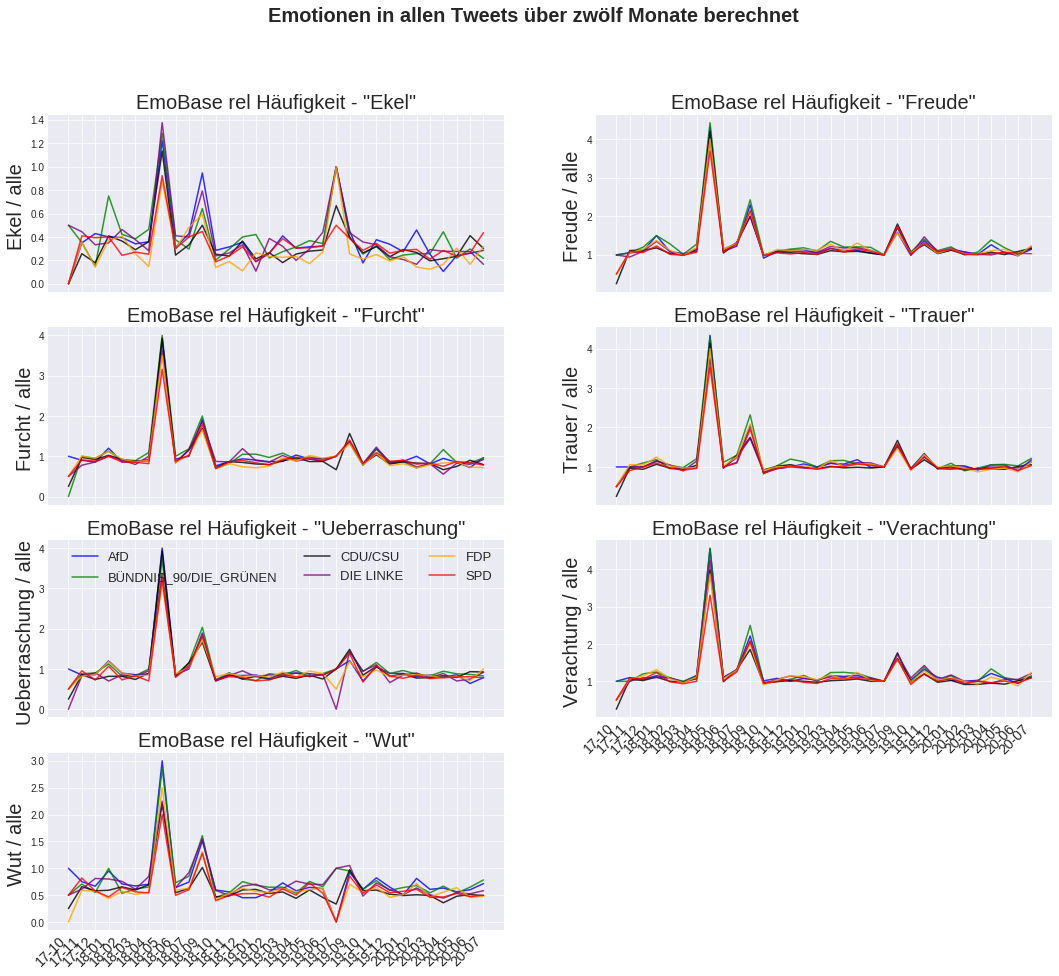

In [68]:
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'green', 'black', 'purple', 'orange', 'red']
fig = plt.figure(figsize = (18, 15))
fig.tight_layout()
fig.suptitle('Emotionen in allen Tweets über zwölf Monate berechnet', fontsize = 20, weight = 'bold')

for emo, n in zip(emotion, range(1,len(emotion)+1)):
    ax = fig.add_subplot(4,2,n)
    
    num=0
    for column in partei_piv_emo_rel[emo]:
        ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo][column], color = my_palette[num], alpha=0.8, label = column)
        num+=1
#     ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['AfD'], marker='', color='blue', linewidth=4, alpha=0.7)
    ax.set_title('EmoBase rel Häufigkeit - "' +emo+ '"', size = 20)
    ylab = ax.set_ylabel(emo +' / alle ', size = 20)
    
    if n <= 5:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_emo_rel.index, fontsize = 14, rotation = 45, ha = "right")
    if n == 5:
        plt.legend(loc = 1, ncol = 3, fontsize = 13)

